# 0. Setup

In [22]:
import numpy as np
from numpy.testing import assert_almost_equal
import pandas as pd
from matplotlib import pyplot as plt

from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

In [23]:
### Helper functions

def covariance_calc(H, k):
    #Calculation derived in dissertation.
    
    return 0.5\
        * (np.abs(k - 1) ** (2 * H)\
         + np.abs(k + 1) ** (2 * H)\
         - 2 * (np.abs(k) ** (2 * H)))

#Test basic functionality
assert_almost_equal(covariance_calc(0.5, 1), 0)
assert_almost_equal(covariance_calc(0.25, 1), -0.2928932)
assert_almost_equal(covariance_calc(0.25, -1), -0.2928932)
assert_almost_equal(covariance_calc(0.75, 4), 0.1882461)

def get_covariance_matrix(n_steps, H):
    #Return an unscaled covariance matrix
    m = np.zeros([n_steps , n_steps])
    k = np.arange(0, n_steps, 1)
    m[:, 0] = covariance_calc(H, k)

    for i in range(1, n_steps):
        m[i:, i] = m[i-1:-1, i-1]
    
    m = np.tril(m) + np.triu(m.T, 1)
    return m

#Test matrix build right
assert_almost_equal(get_covariance_matrix(3, 0.25), np.array([[1, -0.2928932, -0.0481881], [-0.2928932, 1, -0.2928932], [-0.0481881, -0.2928932, 1]]))



In [24]:
def simulate_fbm(n_sims, n_steps, T, H):

    rng = np.random.default_rng(seed = 1729)

    cov_mat = get_covariance_matrix(n_steps, H)
    L = np.linalg.cholesky(cov_mat)
    
    variates = rng.normal(loc = 0, scale = 1, size = [n_sims, n_steps])
    corr_variates = (L @ variates.T).T

    B = np.zeros([n_sims, n_steps + 1])

    for i in range(0, n_steps):
        B[:, i + 1] = B[:, i] + corr_variates[:, i]

    return B * (T/n_steps) ** (H)


    


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


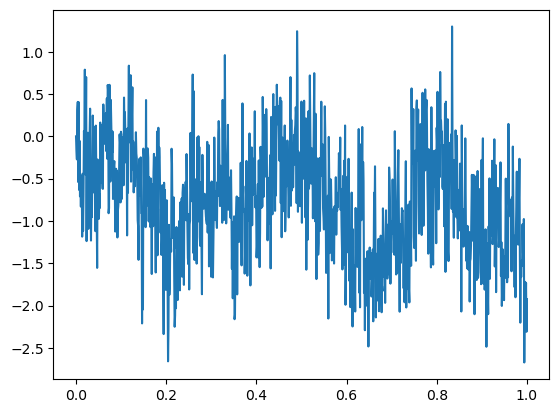

In [25]:
n_steps = 1024
T = 1

span = np.linspace(0, T, n_steps + 1)

out = simulate_fbm(1, n_steps, T, 0.05)
plt.plot(span, out.T)

#out = simulate_fbm(1, n_steps, T, 0.5)
#plt.plot(span, out.T)

#out = simulate_fbm(1, n_steps, T, 0.95)
#plt.plot(span, out.T)

# 1. MLE

In [26]:
#Checking the functionality works - build out in cases where I know what the parameters are

def obj(H, x, T):
    n_steps = x.shape[0]
    R = get_covariance_matrix(n_steps, H)
    scalar = (T / n_steps) ** (H)

    determinant = (scalar ** 2) * np.linalg.det(R)
    R_inv = np.linalg.inv(R) / scalar ** 2

    return np.log(determinant) + np.dot(x.T, np.dot(R_inv, x))
    


def max_MLE(x, T):
    # Test case where mean, variance known

    #Add x_0 value if it is missing
    if x[0,] != 0:
        x = np.insert(x, 0, 0)
    
    diffs = x[1:] - x[:-1]

    H = minimize(obj, 0.5, args = (diffs, T), bounds = [(0.0000001, 0.9999999999)])
    return H.x



In [27]:
x = simulate_fbm(1, 10, 1, 0.5)
x = x[0, :].T

In [33]:
max_MLE(x, 1)

array([1.e-07])

In [29]:
sample_fbm = np.loadtxt('/Users/james.male/Dissertation/fBMPath2.txt')
sample_fbm.shape[0]

1024

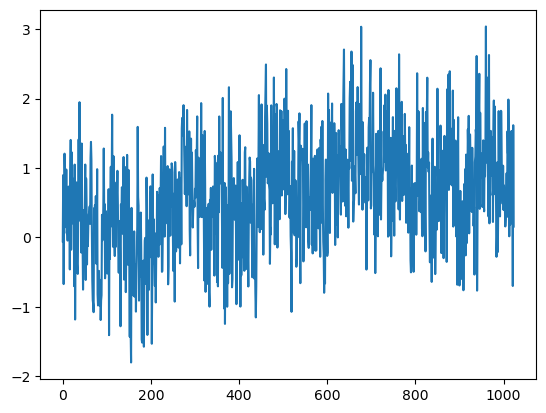

In [30]:
plt.plot(sample_fbm)


In [31]:
def obj_MLE(H, x):
    n_steps = x.shape[0]
    cov_mat = construct_covariance_matrix(n_steps, 1, H)

    det = np.linalg.det(cov_mat)
    log_det = np.log(np.abs(det))

    cov_inv = np.linalg.inv(cov_mat)
    vector_product = n_steps * np.log(1 / n_steps * (x.T @ cov_inv.dot(x)))

    #LLF is negative this, return positive so we can minimize it
    return log_det + 0.5 * vector_product
    

    

In [32]:
obj_MLE(0.99, sample_fbm)

NameError: name 'construct_covariance_matrix' is not defined

In [ ]:
def fbm_MLE(x):
    n_steps = x.shape[0]

    H_hat = minimize(obj_MLE, x0 = 0.5, args = x, bounds = [(0, 0.99999)])
    
    cov_mat = construct_covariance_matrix(n_steps, 1, H_hat)
    sigma_hat = 1 / n_steps * x.T @ cov_mat @ x

    return sigma_hat, H_hat

In [ ]:
fbm_MLE(sample_fbm)

/var/folders/g6/pyz54wsd7_q9hnbzrb7857y80000gp/T/ipykernel_40281/1839311700.py:6: RuntimeWarning: divide by zero encountered in log
  log_det = np.log(np.abs(det))
/Users/james.male/opt/anaconda3/envs/Random_Stuff/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


TypeError: unsupported operand type(s) for *: 'int' and 'OptimizeResult'